In [32]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import re
from geopy.geocoders import Nominatim
from geopy import distance
import holidays

In [33]:
completed_orders = pd.read_csv('../data/nb.csv')
delivery_requests = pd.read_csv('../data/driver_locations_during_request.csv')

In [34]:
delivery_requests.head()

,id,order_id,driver_id,driver_action,lat,lng,created_at,updated_at
0,1,392001,243828,accepted,6.602207,3.270465,NaN,NaN
1,2,392001,243588,rejected,6.592097,3.287445,NaN,NaN
2,3,392001,243830,rejected,6.596133,3.281784,NaN,NaN
3,4,392001,243539,rejected,6.596142,3.280526,NaN,NaN
4,5,392001,171653,rejected,6.609232,3.288800,NaN,NaN


In [35]:
delivery_requests.shape

(1557740, 8)

In [36]:
delivery_requests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


In [37]:
delivery_requests.isna().sum()

id                     0
order_id               0
driver_id              0
driver_action          0
lat                    0
lng                    0
created_at       1557740
updated_at       1557740
dtype: int64

delete the columns created_at and updated_at because there is no data found in them

In [38]:
delivery_requests.drop(columns=['created_at'], inplace=True)
delivery_requests.drop(columns=['updated_at'], inplace=True)

In [39]:
delivery_requests.isna().sum()

id               0
order_id         0
driver_id        0
driver_action    0
lat              0
lng              0
dtype: int64

In [40]:
grouped_delivery=delivery_requests.groupby(["order_id","driver_id","driver_action"],as_index=False).size()
grouped_delivery.head()

,order_id,driver_id,driver_action,size
0,392001,171651,rejected,1
1,392001,171653,rejected,1
2,392001,226949,rejected,1
3,392001,243539,rejected,1
4,392001,243588,rejected,1


In [41]:
grouped_delivery_new=grouped_delivery.groupby(["order_id","driver_action"],as_index=False).size()


grouped_delivery_new.rename(columns={"size":"count"},inplace=True)
grouped_delivery_new.head()


,order_id,driver_action,count
0,392001,accepted,1
1,392001,rejected,9
2,392005,accepted,1
3,392005,rejected,17
4,392009,accepted,1


In [42]:
accepted_orders=grouped_delivery_new[grouped_delivery_new["driver_action"]=="accepted"]
rejected_orders=grouped_delivery_new[~grouped_delivery_new.order_id.isin(accepted_orders.order_id)]

In [43]:
accepted_orders.head()

,order_id,driver_action,count
0,392001,accepted,1
2,392005,accepted,1
4,392009,accepted,1
6,392013,accepted,1
8,392014,accepted,1


In [44]:
rejected_orders.head()

,order_id,driver_action,count
1216,393128,rejected,32
1269,393177,rejected,16
1407,393291,rejected,2
1917,393737,rejected,9
1990,393809,rejected,14


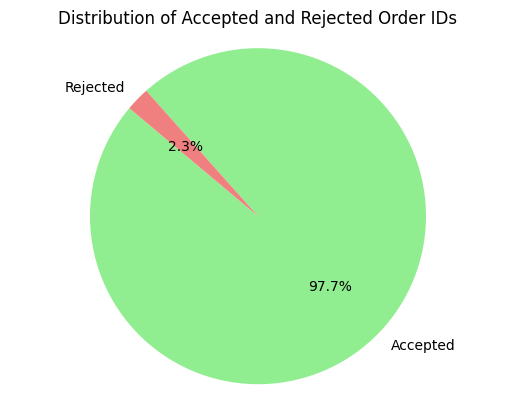

In [45]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrames accepted_orders and rejected_orders as shown in your example

# Counting the number of unique order IDs for accepted and rejected orders
accepted_order_count = accepted_orders['order_id'].nunique()
rejected_order_count = rejected_orders['order_id'].nunique()

# Pie chart labels
labels = ['Accepted', 'Rejected']

# Pie chart data
sizes = [accepted_order_count, rejected_order_count]

# Pie chart colors
colors = ['lightgreen', 'lightcoral']

# Plotting the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Adding a title
plt.title('Distribution of Accepted and Rejected Order IDs')

# Show plot
plt.show()


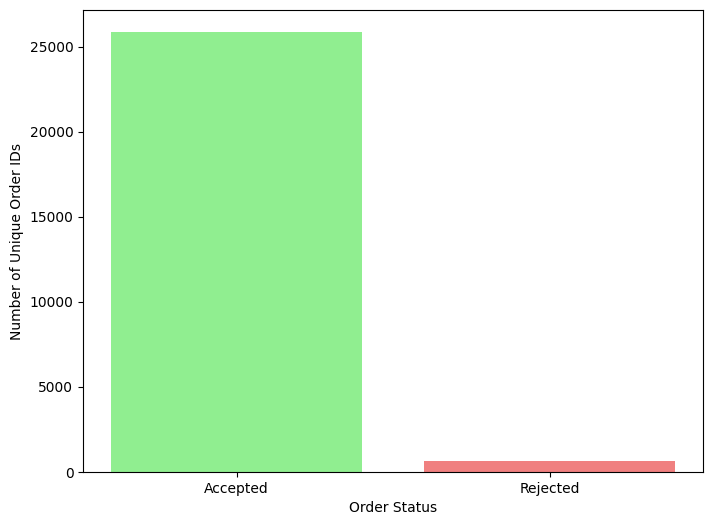

In [46]:
import matplotlib.pyplot as plt

# Assuming you have the DataFrames accepted_orders and rejected_orders as shown in your example

# Counting the number of unique order IDs for accepted and rejected orders
accepted_order_count = accepted_orders['order_id'].nunique()
rejected_order_count = rejected_orders['order_id'].nunique()

# Bar chart labels
labels = ['Accepted', 'Rejected']

# Bar chart data
counts = [accepted_order_count, rejected_order_count]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['lightgreen', 'lightcoral'])

# Adding labels and title
plt.xlabel('Order Status')
plt.ylabel('Number of Unique Order IDs')
plt.show()


merging the two datasets on order_id eqauls trip_id

In [47]:
completed_orders_cleaned = pd.read_csv('../data/completed_orders_cleaned.csv')
completed_orders_cleaned.nunique()

trip_id             536020
trip_origin         112142
trip_destination    147520
trip_start_time     513611
trip_end_time       513855
duration_min         23205
distance            467322
holiday                  2
dtype: int64

In [48]:
delivery_requests.nunique()

id               1557740
order_id           26492
driver_id           1213
driver_action          2
lat               194406
lng               170385
dtype: int64

In [49]:
completed_orders_useful_data = completed_orders_cleaned[["trip_id","trip_origin","trip_start_time","duration_min","holiday"]]

In [50]:
lat = completed_orders_useful_data["trip_origin"].apply(lambda x:x.split(',')[0])
lon = completed_orders_useful_data["trip_origin"].apply(lambda x:x.split(',')[1])
completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
completed_orders_useful_data.rename(columns={"trip_id":"order_id"},inplace=True)
completed_orders_useful_data.drop(columns="trip_origin",inplace=True)

/tmp/ipykernel_5248/2592935453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
/tmp/ipykernel_5248/2592935453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_orders_useful_data['origin_lat'],completed_orders_useful_data['origin_lng']=lat,lon
/tmp/ipykernel_5248/2592935453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [51]:
delivery_requests.rename(columns={"lat":"driver_lat","lng":"driver_lng"},inplace=True)

In [52]:
delivery_requests.to_csv("../data/delivery_requests_cleaned.csv",index=False)

In [53]:
merged_dataframe = delivery_requests.merge(completed_orders_useful_data,on="order_id")
merged_dataframe.to_csv("../data/merged_dataframe.csv",index=False)

In [54]:
merged_df = pd.read_csv('../data/merged_dataframe.csv')
merged_df.head

<bound method NDFrame.head of               id  order_id  driver_id driver_action  driver_lat  driver_lng  \
0              1    392001     243828      accepted    6.602207    3.270465   
1              2    392001     243588      rejected    6.592097    3.287445   
2              3    392001     243830      rejected    6.596133    3.281784   
3              4    392001     243539      rejected    6.596142    3.280526   
4              5    392001     171653      rejected    6.609232    3.288800   
...          ...       ...        ...           ...         ...         ...   
1557735  1557736    517948     243774      rejected    6.469036    3.566877   
1557736  1557737    517948     245447      rejected    6.425431    3.527358   
1557737  1557738    517948     239866      rejected    6.440013    3.525378   
1557738  1557739    517948     243774      rejected    6.469036    3.566877   
1557739  1557740    517948     244170      rejected    6.469390    3.572079   

             trip_sta

In [55]:
delivery_requests_new=delivery_requests.groupby(["order_id","driver_action"],as_index=False).agg(
    {
        "driver_id":"count",
        "driver_lat":"mean",
        "driver_lng":"mean",
    }
    )

In [56]:
delivery_requests_new

,order_id,driver_action,driver_id,driver_lat,driver_lng
0,392001,accepted,1,6.602207,3.270465
1,392001,rejected,9,6.602246,3.280118
2,392005,accepted,1,6.549147,3.392184
3,392005,rejected,50,6.566354,3.376415
4,392009,accepted,1,6.644829,3.289328
...,...,...,...,...,...
51243,497721,rejected,2,6.476228,3.374449
51244,510268,accepted,1,6.462251,3.391023
51245,510268,rejected,3,6.442820,3.418730
51246,517948,accepted,1,6.464150,3.552330


In [57]:
accepted_delivery_orders=delivery_requests_new[delivery_requests_new["driver_action"]=="accepted"]
rejected_delivery_orders=delivery_requests_new[~delivery_requests_new.order_id.isin(accepted_orders.order_id)]

In [58]:
accepted_delivery_orders

,order_id,driver_action,driver_id,driver_lat,driver_lng
0,392001,accepted,1,6.602207,3.270465
2,392005,accepted,1,6.549147,3.392184
4,392009,accepted,1,6.644829,3.289328
6,392013,accepted,1,6.435331,3.424317
8,392014,accepted,1,6.498221,3.360042
...,...,...,...,...,...
51238,489898,accepted,1,6.443810,3.464208
51240,490008,accepted,1,6.448554,3.574380
51242,497721,accepted,1,6.498164,3.359964
51244,510268,accepted,1,6.462251,3.391023


In [59]:
rejected_delivery_orders

,order_id,driver_action,driver_id,driver_lat,driver_lng
1216,393128,rejected,249,6.448078,3.471102
1269,393177,rejected,53,6.433693,3.434249
1407,393291,rejected,2,6.472269,3.595364
1917,393737,rejected,34,6.581892,3.284952
1990,393809,rejected,14,6.432379,3.430111
...,...,...,...,...,...
50859,448163,rejected,50,6.548443,3.367682
50904,448206,rejected,45,6.629031,3.349366
50929,448235,rejected,345,6.599802,3.335208
51067,448373,rejected,30,6.589903,3.346469


In [61]:
# Assuming accepted_delivery_orders and rejected_delivery_orders are DataFrame objects
unique_delivery_orders = pd.concat([accepted_delivery_orders, rejected_delivery_orders])

# Now you can proceed with your merging and renaming operations
clean_merged_df = unique_delivery_orders.merge(completed_orders_useful_data, on="order_id")
clean_merged_df.rename(columns={"driver_id": "action_count"}, inplace=True)

In [62]:
clean_merged_df

,order_id,driver_action,action_count,driver_lat,driver_lng,trip_start_time,duration_min,holiday,origin_lat,origin_lng
0,392001,accepted,1,6.602207,3.270465,2021-07-01 09:30:59,3.616667,False,6.6010417,3.2766339
1,392005,accepted,1,6.549147,3.392184,2021-07-01 10:53:36,34.250000,False,6.565087699999999,3.3844415
2,392009,accepted,1,6.644829,3.289328,2021-07-01 06:39:51,61.350000,False,6.6636484,3.3082058
3,392013,accepted,1,6.435331,3.424317,2021-07-01 08:44:09,35.033333,False,6.4308171,3.4341552
4,392014,accepted,1,6.498221,3.360042,2021-07-01 06:43:07,44.283333,False,6.499156300000001,3.3585173
...,...,...,...,...,...,...,...,...,...,...
26487,448163,rejected,50,6.548443,3.367682,2021-07-09 20:10:45,30.700000,False,6.553579,3.3654461
26488,448206,rejected,45,6.629031,3.349366,2021-07-09 19:07:24,43.416667,False,6.630902699999999,3.342772099999999
26489,448235,rejected,345,6.599802,3.335208,2021-07-13 16:06:15,1.733333,False,6.6076335,3.322855
26490,448373,rejected,30,6.589903,3.346469,2021-07-09 19:18:47,78.933333,False,6.5844933,3.357566


In [63]:
import sys
sys.path.append("../scripts/")
from data_cleaning import CleanData
cleaner = CleanData()

In [64]:
clean_merged_df = cleaner.find_distance(clean_merged_df,distance_col_name="distance_diff",trip_origin_col_names=["driver_lat","driver_lng"],trip_destination_col_names=["origin_lat","origin_lng"])

In [65]:
clean_merged_df=clean_merged_df[["order_id","driver_lat","driver_lng","origin_lat","origin_lng","distance_diff","trip_start_time","duration_min","holiday","action_count","driver_action"]]

if the delivery minute duration is greater than 10 minutes the order is fulfilled but if not the order is not fulfilled

In [66]:
clean_merged_df["fulfilled"] = (clean_merged_df["driver_action"] == "accepted") & (clean_merged_df["duration_min"] >=10)

/tmp/ipykernel_5248/1775922585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_merged_df["fulfilled"] = (clean_merged_df["driver_action"] == "accepted") & (clean_merged_df["duration_min"] >=10)


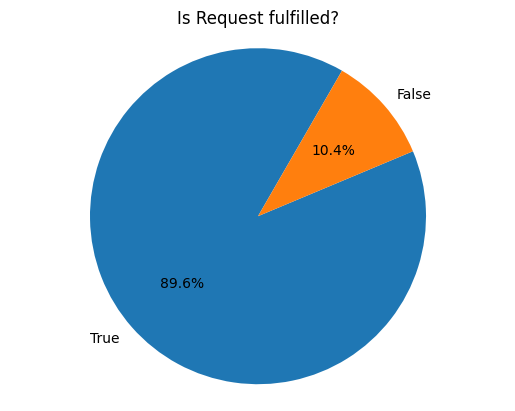

In [67]:
labels= clean_merged_df["fulfilled"].value_counts().index
sizes= ( clean_merged_df["fulfilled"].value_counts())

plt.pie(sizes,labels=labels,startangle=60, autopct='%1.1f%%')

plt.axis('equal')
plt.title("Is Request fulfilled?")

plt.show()

In [69]:
clean_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26492 entries, 0 to 26491
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         26492 non-null  int64  
 1   driver_lat       26492 non-null  float64
 2   driver_lng       26492 non-null  float64
 3   origin_lat       26492 non-null  object 
 4   origin_lng       26492 non-null  object 
 5   distance_diff    26492 non-null  float64
 6   trip_start_time  26492 non-null  object 
 7   duration_min     26492 non-null  float64
 8   holiday          26492 non-null  bool   
 9   action_count     26492 non-null  int64  
 10  driver_action    26492 non-null  object 
 11  fulfilled        26492 non-null  bool   
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 2.1+ MB


In [70]:
clean_merged_df

,order_id,driver_lat,driver_lng,origin_lat,origin_lng,distance_diff,trip_start_time,duration_min,holiday,action_count,driver_action,fulfilled
0,392001,6.602207,3.270465,6.6010417,3.2766339,0.694264,2021-07-01 09:30:59,3.616667,False,1,accepted,False
1,392005,6.549147,3.392184,6.565087699999999,3.3844415,1.959786,2021-07-01 10:53:36,34.250000,False,1,accepted,True
2,392009,6.644829,3.289328,6.6636484,3.3082058,2.947683,2021-07-01 06:39:51,61.350000,False,1,accepted,True
3,392013,6.435331,3.424317,6.4308171,3.4341552,1.197389,2021-07-01 08:44:09,35.033333,False,1,accepted,True
4,392014,6.498221,3.360042,6.499156300000001,3.3585173,0.197853,2021-07-01 06:43:07,44.283333,False,1,accepted,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26487,448163,6.548443,3.367682,6.553579,3.3654461,0.619439,2021-07-09 20:10:45,30.700000,False,50,rejected,False
26488,448206,6.629031,3.349366,6.630902699999999,3.342772099999999,0.757986,2021-07-09 19:07:24,43.416667,False,45,rejected,False
26489,448235,6.599802,3.335208,6.6076335,3.322855,1.617454,2021-07-13 16:06:15,1.733333,False,345,rejected,False
26490,448373,6.589903,3.346469,6.5844933,3.357566,1.365251,2021-07-09 19:18:47,78.933333,False,30,rejected,False


In [71]:
accept_1km=clean_merged_df[(clean_merged_df["distance_diff"]<=1) & (clean_merged_df["driver_action"]=="accepted")].shape[0]
reject_1km=clean_merged_df[(clean_merged_df["distance_diff"]<=1) & (clean_merged_df["driver_action"]=="rejected")].shape[0]

In [72]:
accept_more_1km=clean_merged_df[(clean_merged_df["distance_diff"]>1) & (clean_merged_df["driver_action"]=="accepted")].shape[0]
reject_more_1km=clean_merged_df[(clean_merged_df["distance_diff"]>1) & (clean_merged_df["driver_action"]=="rejected")].shape[0]

In [75]:
print(f"{accept_1km} requests were accepted by drivers within 1km while {reject_1km} were rejected within 1km radius")
print(f"{accept_more_1km} requests were accepted by drivers more than 1km while {reject_more_1km} were rejected more than 1km radius")


8484 requests were accepted by drivers within 1km while 364 were rejected within 1km radius
17397 requests were accepted by drivers more than 1km while 247 were rejected more than 1km radius


In [78]:
acceptance_summary=pd.DataFrame(data=[[accept_1km,reject_1km],[accept_more_1km,reject_more_1km]],columns=["accepted","rejected"],index=["with in 1km","more than 1km"])

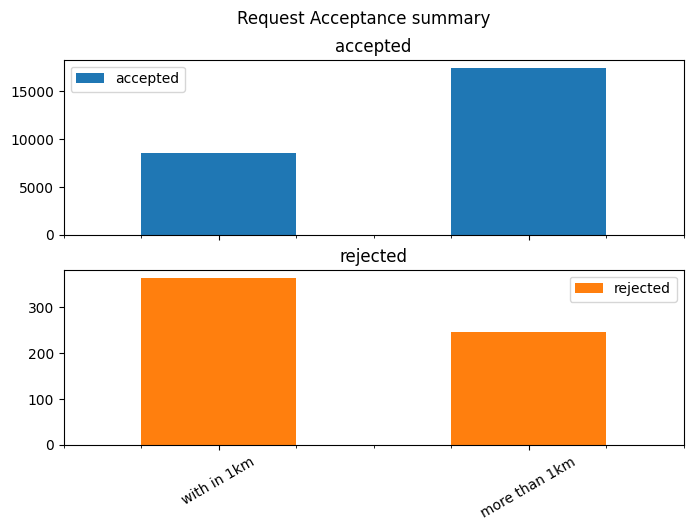

In [79]:
acceptance_summary.plot(kind='bar',subplots=True,rot=30,figsize=(8,5))
plt.suptitle("Request Acceptance summary")
plt.show()